# Inside AirBnB

## Enunciado

Este Notebook consiste en la actividad evaluable correspondiente al Módulo 1 de la Asignatura de Aprendizaje Automático I del Máster en Ingeniería y Ciencia de Datos de la UNED.

La actividad constituye en un ejercicio de clasificación empleando los tres métodos descritos en el tema y la aplicación de varias de las técnicas estudiadas en el Tema 2.

### 1. Datos

Los datos provienen de la web InsideAirBnB, dedicada al estudio de los alquileres vacacionales ofrecidos en la plataforma AirBnB. El fichero está contenido dentro de la carpeta input-data. Este fichero es una versión editada, a fin de facilitar la tarea, del listado original de información sobre las ofertas existentes, para la ciudad de Madrid, en abril de 2017. 

> Contiene 13321 registros con 11 campos cada uno, correspondientes a diferentes características de cada oferta de alojamiento.

La tarea de clasificación consistirá en clasificar los datos según el tipo de alojamiento, definido en el campo `room_type`, a partir del resto de características. Es decir, en room_type estarán codificadas las clases y en el resto de campos los atributos.

### 2. Estudio estadístico y limpieza de datos

Se realizará un breve estudio estadístico de los datos numéricos y de la variable `room_type` se contarán los valores de cada clase. Si las clases no estuvieran balanceadas habrá que usar los mecanismos que puedan tener los algoritmos de clasificación para tratar con este caso. Para Naive Bayes ya se habla de esto en la actividades autoevaluables, para los otros métodos consultar en la documentación de sus APIs los parámetros de los constructores para ver si hay mecanismos para balancear.
En cuanto a la limpieza de datos estudiar si hay datos faltantes, transformar datos categóricos y escalar datos numéricos haciendo uso de pipelines cuando sea posible.

### 3. Entrenamiento y validación

1. Dividir los datos en conjunto de entrenamiento y test de manera que el conjunto de test sea un 20 % del total.
2. Evaluar los modelos midiendo la exactitud (accuracy) usando validación cruzada para los tres métodos estudiados utilizando los parámetros por defecto de los tres métodos, salvo lo comentado para el balance, para cross_val_score usar cv=10. Comparar los resultados de los tres modelos.
3. Realizar la afinación de hiperparámetros para KNN y Árboles de decisión empleando Grid- SearchCV, Naive Bayes no tiene hiperparámetros que afinar.
    1. Para KNN buscando el valor óptimo de K.
    2. Para Árboles de decisión: variando max_leaf_nodes entre 2 y 50 ambos inclusive , min_samples_split entre 2 y 6 ambos inclusive y max_depth entre 1 y 20 ambos in- clusive. Ver la documentación de la API.

### 4. Valoración

Se valorará la creación del código que realice los requisitos enumerados, la presencia de comentarios de lo que hace el código y sus resultados y las comparaciones entre los resultados obtenidos por los distintos algoritmos, así como algún gráfico que muestre los resultados. Para terminar incluir un apartado de conclusiones. Tanto los comentarios como las conclusiones no es necesario que sea extensos, sino que describan de forma concisa.

## Realización del ejercicio

Antes de empezar a "ensuciarnos las manos", vamos a importar todos los paquetes necesarios, de los que iremos haciendo uso a lo largo del ejercicio:

In [1]:
# Pandas
import pandas as pd
from pandas.plotting import scatter_matrix
# Numpy
import numpy as np
# Operator
import operator
# SeaBorn
import seaborn as sns
# Scikit Learn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
# MatplotLib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

### Recogida de datos

En primer lugar, vamos a cargar los datos con los que vamos a trabajar. Estos datos están ubicados en la carpeta "input-data", en un fichero llamado "airbnb.csv". Para ello, usaremos el método `read_csv()` de pandas.

In [2]:
airbnb = pd.read_csv("input-data/airbnb.csv")

## Estudio estadístico y limpieza de datos


Comprobamos que los datos se han cargado correctamente y visualizamos nuestros datos por encima:

In [3]:
airbnb

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Centro,Justicia,40.424715,-3.698638,Entire home/apt,49,28,35,0.42,1,99
1,Centro,Embajadores,40.413418,-3.706838,Entire home/apt,80,5,18,0.30,1,188
2,Moncloa - Aravaca,Argüelles,40.424920,-3.713446,Entire home/apt,40,2,21,0.25,9,195
3,Moncloa - Aravaca,Casa de Campo,40.431027,-3.724586,Entire home/apt,55,2,3,0.13,9,334
4,Latina,Cármenes,40.403410,-3.740842,Private room,16,2,23,0.76,2,250
...,...,...,...,...,...,...,...,...,...,...,...
13316,Centro,Justicia,40.427500,-3.698354,Private room,14,1,0,0.00,1,10
13317,Chamberí,Gaztambide,40.431187,-3.711909,Entire home/apt,47,1,0,0.00,7,354
13318,Centro,Palacio,40.413552,-3.711461,Entire home/apt,60,2,0,0.00,1,17
13319,Centro,Universidad,40.425400,-3.709921,Entire home/apt,150,5,0,0.00,1,15


In [4]:
airbnb.columns

Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [5]:
airbnbXcolumns = ['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']

Seguidamente, realizamos un `describe()` para echarle un ojo a toda la información sobre los datos que tenemos.

In [6]:
airbnb.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


Y también, usamos el método `info()`para ver la estructura de los datos:

In [7]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13321 entries, 0 to 13320
Data columns (total 11 columns):
neighbourhood_group               13321 non-null object
neighbourhood                     13321 non-null object
latitude                          13321 non-null float64
longitude                         13321 non-null float64
room_type                         13321 non-null object
price                             13321 non-null int64
minimum_nights                    13321 non-null int64
number_of_reviews                 13321 non-null int64
reviews_per_month                 13321 non-null float64
calculated_host_listings_count    13321 non-null int64
availability_365                  13321 non-null int64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.1+ MB


Las conclusiones que podemos sacar visualizando la siguiente información son las siguientes:
- No hay valores a `null` ya que todos los `count` tienen el mismo valor.
- `neighbourhood_group`, `neighbourhood` y `room_type`son features categoricas.

Ahora, vamos a crear un nuevo dataset a partir del existente para ver y estudiar los datos que tenemos:

In [8]:
airbnb_est = airbnb.copy()

Mostramos el gráfico de como estarían ubicadas las diferentes viviendas con un valor alpha de 0.1 para ver con facilidad donde están concentradas:

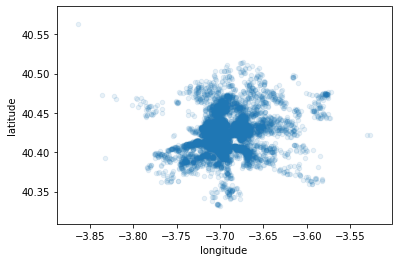

In [9]:
airbnb_est.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

A esto, le añadimos un color diferente a cada `room_type`. Podemos observar con facilidad como las viviendas "Shared room" están concentradas prácticamente en el centro, mientras que el resto están dispersas por toda la ciudad:

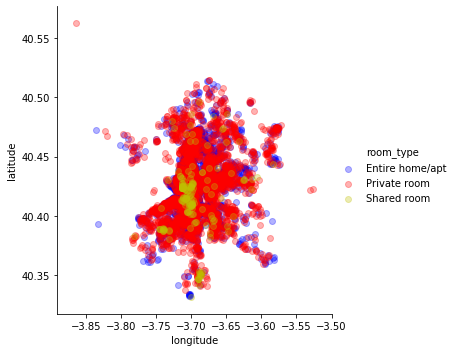

In [10]:
sns.lmplot('longitude', 'latitude', data=airbnb_est, hue='room_type', fit_reg=False, palette=("b", "r", "y"), scatter_kws={'alpha':0.3})
plt.show()

Mostramos la `scatter_matrix` para ver la relación que guardan todas las variables entre sí:

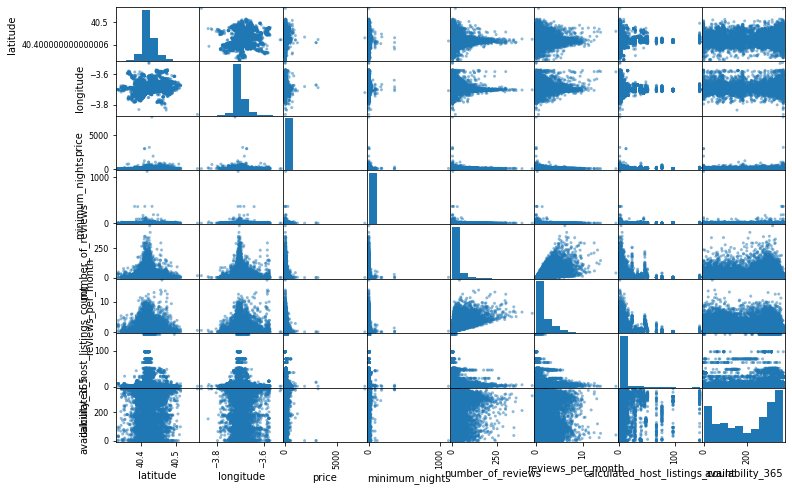

In [11]:
scatter_matrix = scatter_matrix(airbnb_est[airbnb_est.columns], figsize=(12,8))

Para ver mejor los datos estadísticos, vamos a quitar los 'outliers' al dataset del que estamos haciendo uso para el estudio de datos para ver con mejor claridad los rangos de valores:

In [12]:
# pasar a pipeline
q = airbnb_est["price"].quantile(0.98)
airbnb_est = airbnb_est[airbnb_est["price"] < q]

# pasar a pipeline
q = airbnb_est["minimum_nights"].quantile(0.9999)
airbnb_est = airbnb_est[airbnb_est["minimum_nights"] < q]

Comparamos el `price` y `room_type`

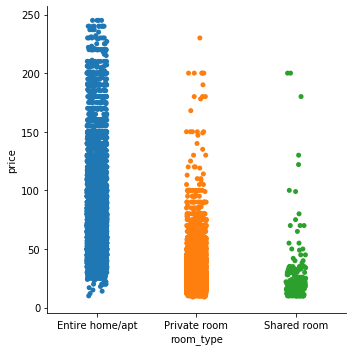

In [13]:
sns.catplot(x="room_type", y="price", data=airbnb_est);

Comparamos el `availability_365` y `room_type`

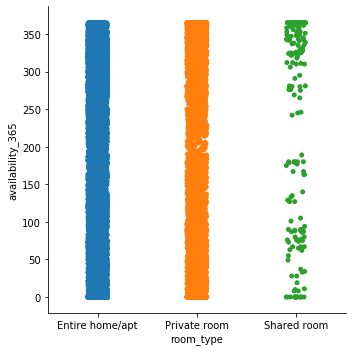

In [14]:
sns.catplot(x="room_type", y="availability_365", data=airbnb_est)

Comparamos el `minimum_nights` y `room_type`

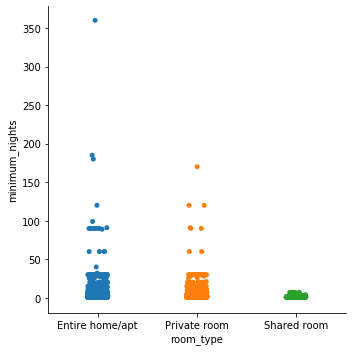

In [15]:
sns.catplot(x="room_type", y="minimum_nights", data=airbnb_est)

Comparamos el `reviews_per_month` y `room_type`

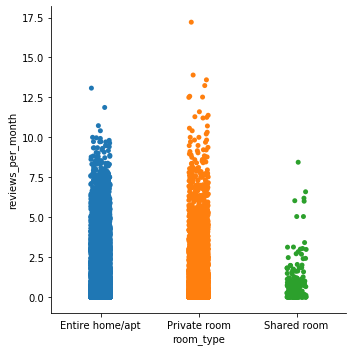

In [16]:
sns.catplot(x="room_type", y="reviews_per_month", data=airbnb_est)

Comparamos el `calculated_host_listings_counts` y `room_type`

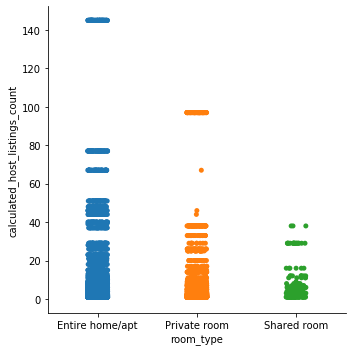

In [17]:
sns.catplot(x="room_type", y="calculated_host_listings_count", data=airbnb_est)

A continuación, observamos los estadístidos de `price` dado el `room_type`

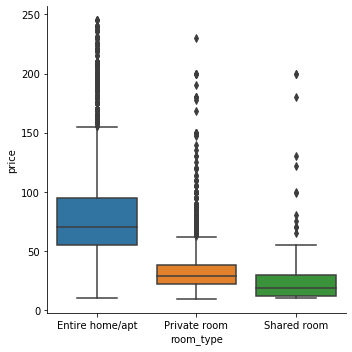

In [18]:
sns.catplot(x="room_type", y="price", kind="box", data=airbnb_est);

Comparamos `price` con `neighbourhood_group`

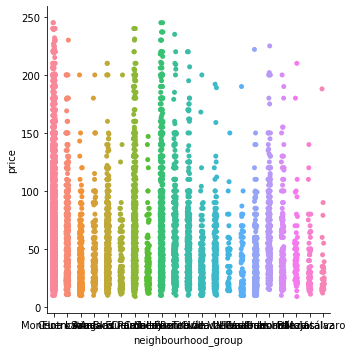

In [19]:
sns.catplot(x="neighbourhood_group", y="price", data=airbnb_est)

Y finalmente vemos el histograma de todas las variables contínuas del dataset.

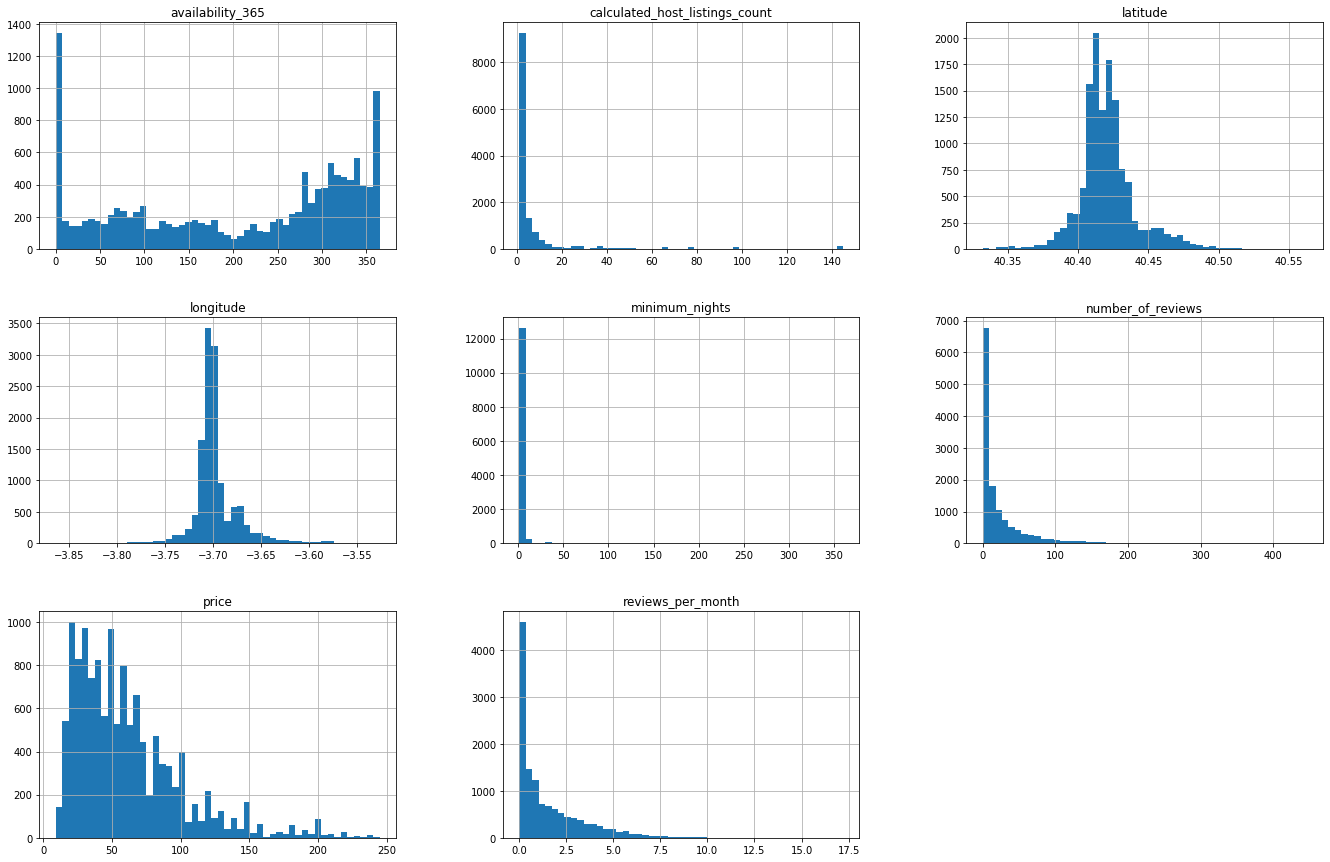

In [20]:
airbnb_est.hist(bins=50, figsize=(23,15))
plt.show()

## Creación del test set

En primer lugar, vamos a eliminar los registros cuyos datos sean únicos para asegurar la consistencia entre el train_set y el test_set:

In [21]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_indices, test_indices in split.split(airbnb, airbnb["room_type"]):
    strat_train_set = airbnb.loc[train_indices]
    strat_test_set = airbnb.loc[test_indices]

In [22]:
X_train = strat_train_set
X_test = strat_test_set
y_train = X_train["room_type"]
y_test = X_test["room_type"]
X_train.drop(columns=["room_type"], inplace=True)
X_test.drop(columns=["room_type"], inplace=True)

In [23]:
y_train.value_counts()

Entire home/apt    6340
Private room       4162
Shared room         154
Name: room_type, dtype: int64

## Naive Baye's

En este caso, tenemos variables multinomiales y variables continuas, para hacer uso del algoritmo de clasificación de Naive Bayes, tenemos dos opciones:

1. Transformar todos sus datos en una representación categórica calculando los percentiles para cada variable continua y luego agrupando las variables continuas utilizando los percentiles como límites, asegurándonos de que cada contenedor contiene aproximadamente el 20% del training set.

2. Ajustar independientemente un modelo NB gaussiano en la parte continua de los datos y un modelo NB multinomial en la parte categórica. Luego, transformar todo el conjunto de datos tomando las probabilidades de asignación de clases (con el método predict_proba) como nuevas características: np.hstack ((multinomial_probas, gaussian_probas)) y luego vuelva a ajustar un nuevo modelo (por ejemplo, un nuevo NB gaussiano) en las nuevas características.

Vamos a realizar la opción 1 ya que la segunda la veremos más adelante en el temario.

En primer lugar, vamos a diseñar nuestro propio transformador de columnas `DFCategorizer`. Este va a transformar todas las variables contínuas en variables categóricas tomando como límite entre las mismas los percentiles. Por defecto, clasificará cada columna en 5 diferentes categorías (tomará por lo tanto los percentiles 0, 0.2, 0.4, 0.6, 0.8 y 1). Sin embargo, si al constructor le especificamos otro número de categorías, lo transformará en tantas categorías como le digamos.

In [24]:
class DFCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self, category, num_cats=5):
        self.category = category
        self.bins = [0]
        self.labels = [0]
        self.num_cats = num_cats
        count = 1
        jump = 1 / num_cats
        cat = jump
        while cat < 1:
            self.bins.append(cat)
            self.labels.append(count)
            count+=1
            cat += jump
        self.bins.append(1)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        bins = []
        for val in self.bins:
            bins.append(X[self.category].quantile(val))
            
        X[self.category] = pd.cut(X[self.category], 
                                    bins=[*bins],
                                    labels=self.labels,
                                    include_lowest=True)
        return X

A continuación, creamos el `ColumnTransformer`, en el cual a las variables categóricas `neighbourhood_group` y `neighbourhood` las transformaremos en ordinales, y al resto de variables contínuas las transformaremos con el `DFCategorizer`creado anteriormente:

In [25]:
full_pipeline = ColumnTransformer([
    ("neighbourhood_col", OrdinalEncoder(), ["neighbourhood_group", "neighbourhood"]),
    ('categorization_latitude', DFCategorizer('latitude'), ["latitude"]),
    ('categorization_longitude', DFCategorizer('longitude'), ["longitude"]),
    ('categorization_price', DFCategorizer('price'), ["price"]),
    ('categorization_min_nights', DFCategorizer('minimum_nights', 2), ["minimum_nights"]),
    ('categorization_number_of_reviews', DFCategorizer('number_of_reviews', 3), ["number_of_reviews"]),
    ('categorization_reviews_per_month', DFCategorizer('reviews_per_month', 3), ["reviews_per_month"]),
    ('categorization_calculated_host_listings_count', DFCategorizer('calculated_host_listings_count', 2), ["calculated_host_listings_count"]),
    ('categorization_availability_365', DFCategorizer('availability_365'), ["availability_365"])
], remainder='passthrough')

X_train_nb_prepared = full_pipeline.fit_transform(X_train)

Comprobamos el resultado de la transformación:

In [26]:
X_train_nb_prepared = pd.DataFrame(data=X_train_nb_prepared, columns=airbnbXcolumns)

In [27]:
X_train_nb_prepared

,neighbourhood_group,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,3.0,115.0,3.0,2.0,3.0,1.0,1.0,1.0,0.0,1.0
1,1.0,113.0,4.0,4.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,61.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0
3,3.0,49.0,1.0,2.0,4.0,0.0,2.0,2.0,0.0,3.0
4,3.0,115.0,3.0,2.0,3.0,0.0,0.0,2.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
10651,3.0,115.0,3.0,1.0,3.0,0.0,0.0,0.0,0.0,4.0
10652,3.0,112.0,2.0,1.0,0.0,0.0,2.0,1.0,1.0,4.0
10653,3.0,115.0,3.0,2.0,0.0,0.0,1.0,2.0,0.0,1.0
10654,10.0,16.0,4.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0


Una vez tenemos nuestros datos categorizados, usaremos el clasificador de Naive Bayes `ComplementNB`. Vamos a hacer uso de este ya que, para clasificadores multinomiales cuyas variables son categóricas, podemos usar tanto este como el algoritmo clasificador `MultinomialNB`. La diferencia entre ambos es que el `ComplementNB`es para datos no balanceados. Como nuestro model no lo está, usaremos el este.

In [28]:
complement_nb_model = ComplementNB()
complement_nb_model.fit(X_train_nb_prepared, y_train)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

In [29]:
complement_nb_scores = cross_val_score(complement_nb_model, X_train_nb_prepared, y_train, cv=5)

In [30]:
complement_nb_scores

array([0.79409006, 0.7879925 , 0.79258564, 0.7930549 , 0.78685446])

Aparentemente los resultados son "decentes". Sin embargo, es engañoso, pues no ha clasificado correctamente ninguna propiedad cuyo valor de `room_type` es 'Shared room'.

In [31]:
confusion_matrix(y_train, cross_val_predict(complement_nb_model, X_train_nb_prepared, y_train, cv=5))

array([[5425,  915,    0],
       [1159, 3003,    0],
       [  24,  130,    0]])

Finalmente, tratamos de predecir nuestro set de pruebas:

In [32]:
X_test_transformed = full_pipeline.fit_transform(X_test)

In [33]:
nb_predictions = complement_nb_model.predict(X_test_transformed)

In [34]:
confusion_matrix(y_test.array, nb_predictions)

array([[1354,  232,    0],
       [ 288,  753,    0],
       [   8,   30,    0]])

#### Conclusiones:

Como podemos comprobar, la predicción de nuestro algoritmo de Naive Baye's no es buena, pues no ha clasificado correctamente ninguna propiedad 'Shared room'. Nuestro modelo contiene una gran cantidad de datos contínuos, y también de datos categóricos. Como Naive Baye's no contempla el trabajar con ambos, la solución es una de las dos propuestas al inicio del ejercicio (categorizar todos los datos). La otra solución habría sido tratar por separado los datos contínuos y los categóricos, cosa que será estudiada en el temario más adelante.

Una solución adicional habría sido no tratar los datos categóricos y haber entrenado un algoritmo GaussianNB solo con los datos contínuos que poseíamos. No obstante, estaríamos dejando de lado datos significativos.

## KNearestNeighbors

Para la realización del algoritmo de `KNeighbors`, vamos a trabajar con todos los datos que tenemos. En primer lugar, transformaremos las variables categóricas en un valor numérico haciendo uso del `OrdionalEncoder`:

In [35]:
X_train_knn_transformer = ColumnTransformer([
    ("neighbours_onehot", OrdinalEncoder(), ["neighbourhood_group", "neighbourhood"])
], remainder='passthrough')

X_train_knn_prepared = X_train_knn_transformer.fit_transform(X_train)

In [36]:
X_train_knn_prepared

array([[3.00000000e+00, 1.15000000e+02, 4.04276455e+01, ...,
        1.25000000e+00, 2.00000000e+00, 7.10000000e+01],
       [1.00000000e+00, 1.13000000e+02, 4.04734953e+01, ...,
        0.00000000e+00, 1.00000000e+00, 7.40000000e+01],
       [0.00000000e+00, 6.10000000e+01, 4.04083054e+01, ...,
        9.00000000e-02, 1.00000000e+00, 0.00000000e+00],
       ...,
       [3.00000000e+00, 1.15000000e+02, 4.04289651e+01, ...,
        7.67000000e+00, 1.00000000e+00, 1.33000000e+02],
       [1.00000000e+01, 1.60000000e+01, 4.04331826e+01, ...,
        1.67000000e+00, 1.00000000e+00, 0.00000000e+00],
       [3.00000000e+00, 6.30000000e+01, 4.04240391e+01, ...,
        1.22000000e+00, 2.00000000e+00, 2.92000000e+02]])

Seguidamente, probamos a entrenar el clasificador `KNearestNeighbors` con un valor de k aleatorio (k=3)

In [37]:
k = 5

knn_model = KNeighborsClassifier(n_neighbors=k)
knn_model.fit(X_train_knn_prepared, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [38]:
cross_val_score(knn_model, X_train_knn_prepared, y_train, cv=5)

array([0.87148218, 0.88602251, 0.86672924, 0.87752229, 0.86995305])

In [39]:
confusion_matrix(y_train, cross_val_predict(knn_model, X_train_knn_prepared, y_train, cv=5))

array([[5823,  517,    0],
       [ 676, 3478,    8],
       [  12,  126,   16]])

#### Buscamos el valor óptimo de k haciendo uso de GridSearchCV

In [40]:
grid_params = {
    'n_neighbors': list(range(1, 40)),
    'metric': ['euclidean', 'manhattan'],
    'weights': ['distance']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose=1,
    cv=5,
    n_jobs=-1
)

gs_results = gs.fit(X_train_knn_prepared, y_train)

Fitting 5 folds for each of 78 candidates, totalling 390 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 375 out of 390 | elapsed:   10.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 390 out of 390 | elapsed:   10.4s finished


Mostramos los mejores valores

In [41]:
print(gs_results.best_score_)
print(gs_results.best_estimator_)
print(gs_results.best_params_)

0.8844782282282282
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='distance')
{'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}


Aplicamos nuestro algoritmo a la variable de test para observar los resultados:

In [42]:
knn_model = KNeighborsClassifier(n_neighbors=11, metric='manhattan')
knn_model.fit(X_train_knn_prepared, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',
                     metric_params=None, n_jobs=None, n_neighbors=11, p=2,
                     weights='uniform')

In [43]:
X_test_knn_prepared = X_train_knn_transformer.fit_transform(X_test)

In [44]:
X_test_knn_prepared

array([[3.00000000e+00, 4.60000000e+01, 4.04108369e+01, ...,
        3.30000000e-01, 6.70000000e+01, 1.11000000e+02],
       [5.00000000e+00, 1.30000000e+01, 4.04309094e+01, ...,
        2.00000000e+00, 3.00000000e+00, 3.56000000e+02],
       [1.50000000e+01, 1.50000000e+01, 4.04274542e+01, ...,
        7.00000000e-02, 6.00000000e+00, 3.40000000e+02],
       ...,
       [3.00000000e+00, 3.80000000e+01, 4.04131295e+01, ...,
        0.00000000e+00, 1.00000000e+00, 4.40000000e+01],
       [5.00000000e+00, 5.10000000e+01, 4.04375869e+01, ...,
        3.00000000e-01, 2.00000000e+00, 1.79000000e+02],
       [1.30000000e+01, 7.40000000e+01, 4.04012093e+01, ...,
        1.03000000e+00, 3.00000000e+00, 3.28000000e+02]])

In [45]:
confusion_matrix(y_test.array, knn_model.predict(X_test_knn_prepared))

array([[1475,  111,    0],
       [ 153,  888,    0],
       [   8,   27,    3]])

#### Conclusión

A pesar de que se ha notado mucha mejoría usando este algoritmo en cuanto al "accuracy", seguimos sin conseguir clasificar correctamente el `room_type` cuyo valor es "Shared Room". Bajo mi perspectiva, la proporción de este es demasiado baja como para que el algoritmo de KNeighbors consiga y sea capaz de conseguir que sea notable sobre el resto de clases.

## Decision Tree Classifier

In [46]:
y_train.value_counts()

Entire home/apt    6340
Private room       4162
Shared room         154
Name: room_type, dtype: int64

Para acabar con el ejercicio práctico, vamos a entrenar el algoritmo `DecisionTreeClassifier` para nuestro dataset de ArinBnB.

En primer lugar crearemos el `ColumnTransformer` en el que transformaremos los datos categóricos en ordinales dándole un valor a cada clase.

In [47]:
X_train_tree_transformer = ColumnTransformer([
    ("neighbours_onehot", OrdinalEncoder(), ["neighbourhood_group", "neighbourhood"])
], remainder='passthrough')

X_train_tree_prepared = X_train_tree_transformer.fit_transform(X_train)

Seguidamente, entrenamos nuestro modelo clasificador:

In [48]:
tree_model = DecisionTreeClassifier(max_depth=7, class_weight='balanced', random_state=42)

tree_model.fit(X_train_tree_prepared, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

Y lo probamos consigo mismo mediante la funcion `cross_val_predict()`:

In [49]:
tree_predictions = cross_val_predict(tree_model, X_train_tree_prepared, y_train, cv=5)

Como se puede observar en la `confusion_matrix`, este clasificador, aunque siga sin hacerlo de bien, ya nos clasifica muchísimas más propiedades 'Shared room' correctamente

In [50]:
confusion_matrix(y_train.array, tree_predictions)

array([[5630,  578,  132],
       [ 464, 2900,  798],
       [   7,   78,   69]])

In [51]:
cross_val_score(tree_model, X_train_tree_prepared, y_train, cv=10)

array([0.82755389, 0.79850047, 0.79831144, 0.81332083, 0.78497653,
       0.81877934, 0.80187793, 0.8       , 0.82159624, 0.75305164])

In [52]:
tree_model.predict_proba(X_train_tree_prepared)

array([[0.92212005, 0.07787995, 0.        ],
       [0.09941084, 0.64014919, 0.26043997],
       [0.75672284, 0.17480817, 0.068469  ],
       ...,
       [0.13664454, 0.86335546, 0.        ],
       [0.83594276, 0.16405724, 0.        ],
       [0.13664454, 0.86335546, 0.        ]])

Seguidamente realizamos una búsqueda con ayuda de `GridSearchCV`para encontrar el mejor hiperparámetro para nuestro algoritmo.

In [53]:
tree_para = {
    'class_weight': ['balanced'],
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]
}

clf = GridSearchCV(
    DecisionTreeClassifier(), 
    tree_para, 
    cv=5)

clf.fit(X_train_tree_prepared, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                      

In [54]:
print(clf.best_score_)
print(clf.best_estimator_)
print(clf.best_params_)

0.8594219219219219
DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 30}


Por lo tanto, los mejores hiperparámetros para entrenar nuestro clasificador son:
- class_weight : 'balanced'
- criterion : 'entropy'
- max_depth: 30

Entrenamos nuestro clasificador:

In [55]:
dec_tree_model = DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=30)

In [56]:
dec_tree_model.fit(X_train_tree_prepared, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [57]:
tree_predictions = cross_val_predict(dec_tree_model, X_train_tree_prepared, y_train, cv=5)

In [58]:
confusion_matrix(y_train.array, tree_predictions)

array([[5670,  663,    7],
       [ 624, 3440,   98],
       [  15,   96,   43]])

In [59]:
cross_val_score(tree_model, X_train_tree_prepared, y_train, cv=5)

array([0.80393996, 0.82410882, 0.77850774, 0.82355702, 0.80469484])

Y lo probamos con el set de test:

In [60]:
X_test_tree_prepared = X_train_tree_transformer.fit_transform(X_test)

In [61]:
X_test_tree_prepared

array([[3.00000000e+00, 4.60000000e+01, 4.04108369e+01, ...,
        3.30000000e-01, 6.70000000e+01, 1.11000000e+02],
       [5.00000000e+00, 1.30000000e+01, 4.04309094e+01, ...,
        2.00000000e+00, 3.00000000e+00, 3.56000000e+02],
       [1.50000000e+01, 1.50000000e+01, 4.04274542e+01, ...,
        7.00000000e-02, 6.00000000e+00, 3.40000000e+02],
       ...,
       [3.00000000e+00, 3.80000000e+01, 4.04131295e+01, ...,
        0.00000000e+00, 1.00000000e+00, 4.40000000e+01],
       [5.00000000e+00, 5.10000000e+01, 4.04375869e+01, ...,
        3.00000000e-01, 2.00000000e+00, 1.79000000e+02],
       [1.30000000e+01, 7.40000000e+01, 4.04012093e+01, ...,
        1.03000000e+00, 3.00000000e+00, 3.28000000e+02]])

In [62]:
confusion_matrix(y_test.array, dec_tree_model.predict(X_test_tree_prepared))

array([[1404,  179,    3],
       [ 180,  844,   17],
       [   5,   19,   14]])

### Conclusion

Indudablemente, este ha sido el algoritmo clasificador que mejor ha ido de los tres que hemos entrenado. No obstante, bajo mi punto de vista, no hemos encontrado ninguno que se ajuste y que realice buenas predicciones, ya que hay una clase ('Shared room') que ningún algoritmo acaba de predecir de forma correcta. Suelen clasificarla como 'Private Room'. 

Esto puede deberse a el balanceo de clases, por mucho que nuestro algoritmos cuenten con métodos para tener en cuenta dicho balanceo, es muy difícil conseguirlo ya que les falta mucha información sobre esta clase comparada con las demás, por lo que es complicado conseguir tener un buen clasificador con tan solo 154 muestras para dicha clase.

## Opinión sobre la práctica

Esta práctica me ha gustado mucho (ya que la asignatura también me gusta). No obstante, me gustaría remarcar tres puntos fuertes y tres puntos que podrían mejorarse de la misma:

- Puntos fuertes
    - Capacidad de llevar a la práctica todos los conceptos aprendidos en la unidad 2 sobre como conseguir un modelo predictivo de principio a fin (end-to-end)
    - Orientacion de la práctica en cuanto a la búsqueda de información y apoyo con los compañeros por el foro.
    - Aplicación de más de un algoritmo para un mismo caso. Nos permite ver las diferencias entre ellos y poder analizar de primera mano, cuál es el más apropiado y por qué.
- Puntos débiles
    - Sobretodo para la primera práctica, estaría bien tener un target (objetivo) para saber cual es la meta a alcanzar para cada algoritmo.
    - El tiempo consumido en la realización de la prática ha excedido el tiempo estimado para la realización de la misma. Esto puede ser debido a que he necesitado volver a estudiar los conceptos de nuevo que creía haber entendido y que probablemente no era así.
        
Para resumir:
He asimilado conceptos aprendidos en el primer módulo y me ha preparado para tener una idea básica sobre los modelos clasificadores. Me han entrado más ganas de avanzar y coger esta asignatura con ganas.